In [57]:
# Import library yang diperlukan
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mediapipe as mp
from scipy.spatial import distance
import os
import random
import matplotlib.pyplot as plt

3. Load Gambar

Total frame yang diekstrak dari kantuk1.mp4: 130
Total frame yang diekstrak dari kantuk2.mp4: 652
Total frame yang diekstrak dari kantuk3.mp4: 217
Total frame yang diekstrak dari tidak_kantuk1.mp4: 239
Total frame yang diekstrak dari tidak_kantuk2.mp4: 241
Menyimpan frame dari video: kantuk1.mp4
Menyimpan frame dari video: kantuk2.mp4
Menyimpan frame dari video: kantuk3.mp4
Menyimpan frame dari video: tidak_kantuk1.mp4
Menyimpan frame dari video: tidak_kantuk2.mp4
Menampilkan 5 frame dari video: kantuk1.mp4


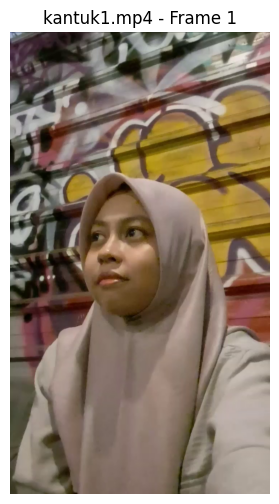

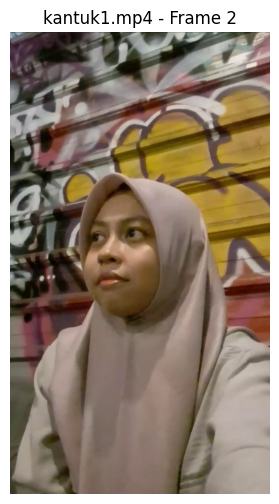

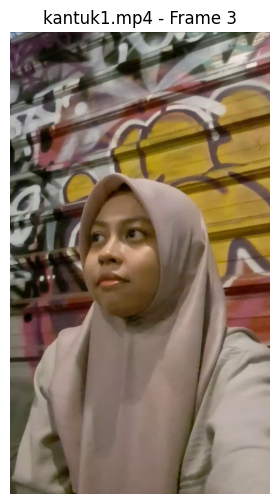

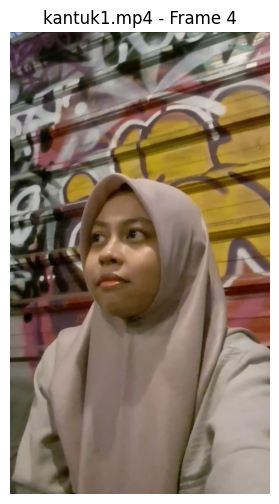

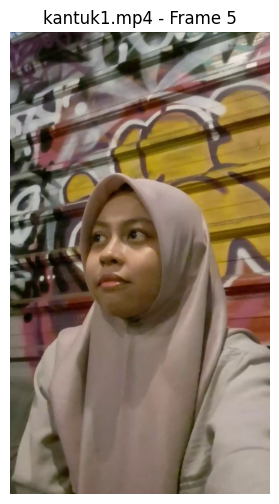

Menampilkan 5 frame dari video: kantuk2.mp4


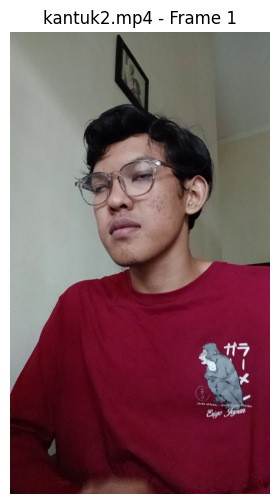

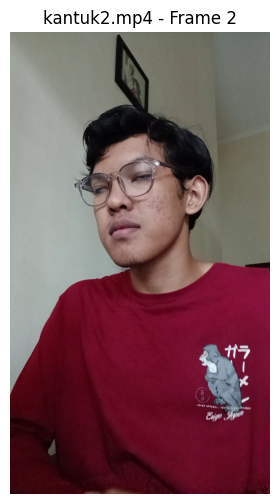

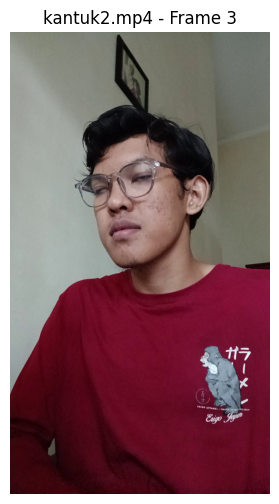

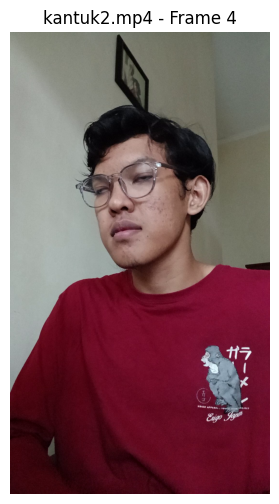

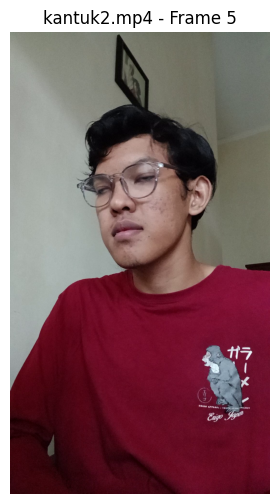

Menampilkan 5 frame dari video: kantuk3.mp4


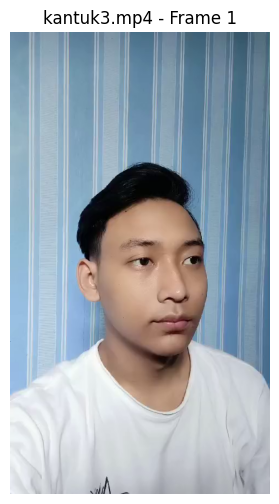

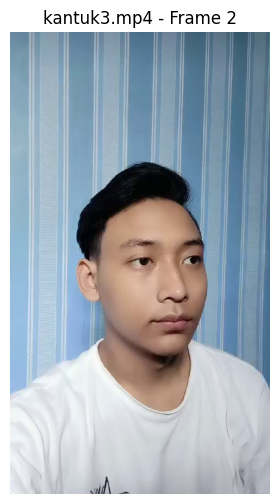

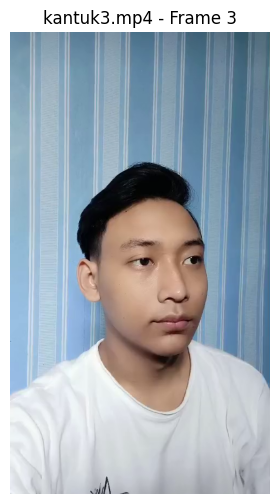

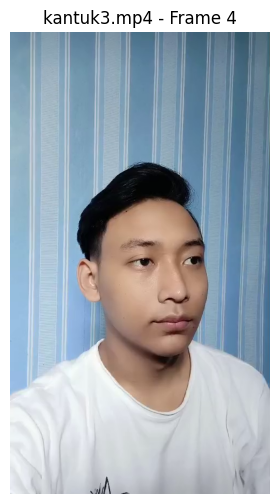

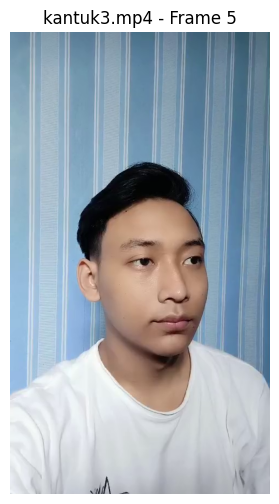

Menampilkan 5 frame dari video: tidak_kantuk1.mp4


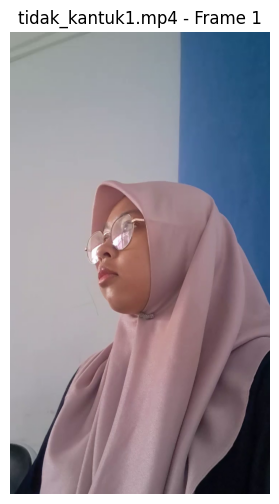

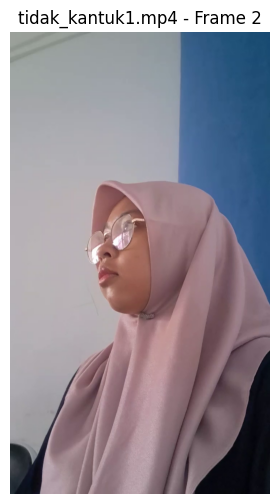

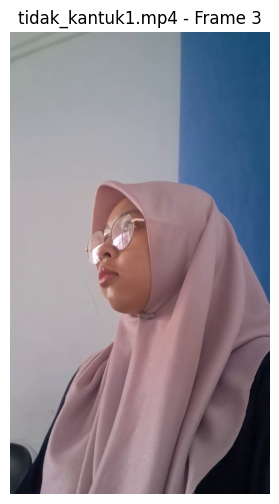

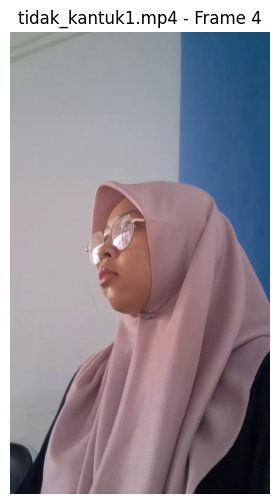

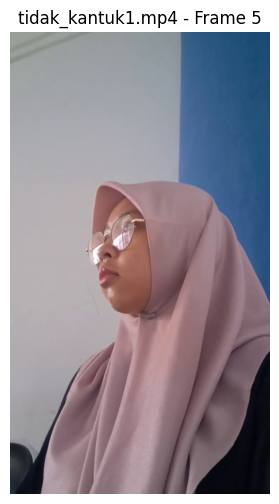

Menampilkan 5 frame dari video: tidak_kantuk2.mp4


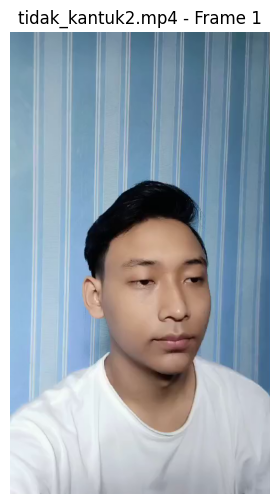

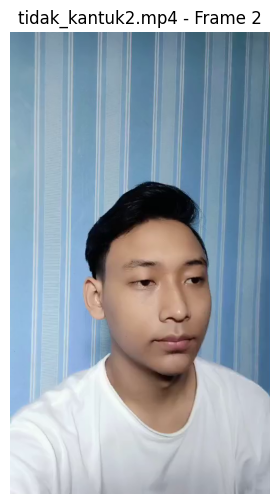

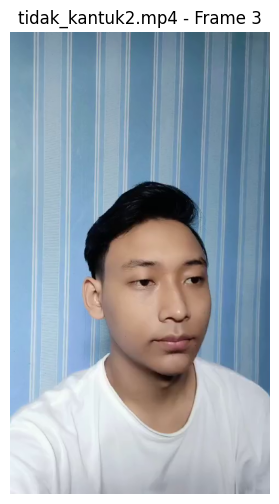

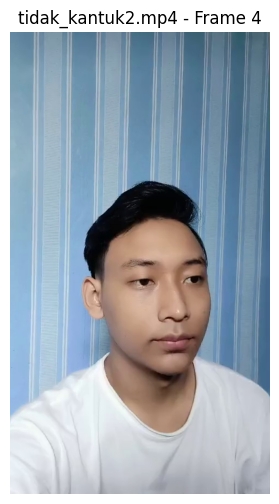

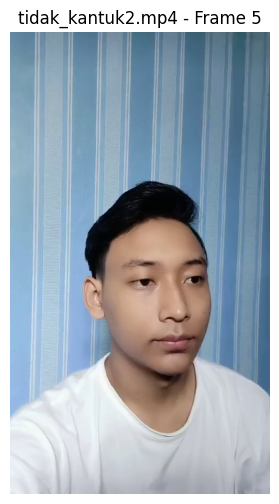

In [58]:
import cv2
import os
import random
import matplotlib.pyplot as plt

# Folder tempat video berada
video_folder_kantuk = 'Dataset/kantuk'
video_folder_non_kantuk = 'Dataset/tidak kantuk'

# Fungsi untuk membaca file video dalam folder tertentu
def get_video_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.mp4') or f.endswith('.avi')]

# Menggabungkan semua video dari kedua folder
video_files_kantuk = get_video_files(video_folder_kantuk)
video_files_non_kantuk = get_video_files(video_folder_non_kantuk)

all_video_files = video_files_kantuk + video_files_non_kantuk

# Fungsi untuk ekstrak frame dari video
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Tidak dapat membuka video {video_path}.")
        return []

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:  # Hentikan jika video selesai
            break
        frames.append(frame)
    cap.release()
    return frames

# Ekstrak frame dari semua video
all_frames = {}  # Dictionary untuk menyimpan frame dari setiap video
for video_file in all_video_files:
    frames = extract_frames(video_file)
    video_name = os.path.basename(video_file)
    all_frames[video_name] = frames
    print(f"Total frame yang diekstrak dari {video_name}: {len(frames)}")

    # Debugging: Cek jika frame yang diekstrak benar
    if len(frames) == 0:
        print(f"Warning: Tidak ada frame yang diekstrak dari {video_name}.")

# Gunakan semua frame dari setiap video untuk diproses
frames_per_video = {
    video: frames for video, frames in all_frames.items()
}

# Simpan frame dalam list (daftar semua frame dari semua video)
all_extracted_frames = []  # List untuk menyimpan semua frame
for video_name, frames in frames_per_video.items():
    print(f"Menyimpan frame dari video: {video_name}")
    
    # Menambahkan semua frame ke list
    all_extracted_frames.extend(frames)

# Tampilkan 5 frame dari setiap video
for video_name, frames in frames_per_video.items():
    print(f"Menampilkan 5 frame dari video: {video_name}")

    # Pastikan hanya 5 frame yang akan ditampilkan
    frames_to_display = frames[:5]

    for i, frame in enumerate(frames_to_display):
        # Konversi frame dari BGR (OpenCV) ke RGB (Matplotlib)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Plot gambar
        plt.figure(figsize=(6, 6))
        plt.imshow(frame_rgb)
        plt.title(f"{video_name} - Frame {i + 1}")
        plt.axis('off')
        plt.show()

# `all_extracted_frames` sekarang berisi semua frame dari semua video.


In [59]:
print(f"{len(all_extracted_frames)}")

1479


### 4.1. Pre-processing: BGR ke Grayscale, HOG Face Detector,

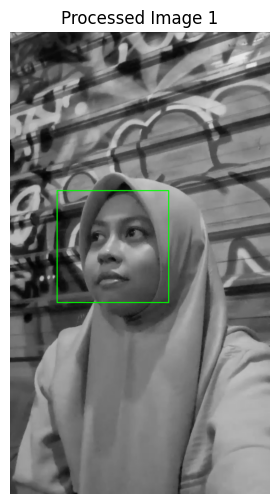

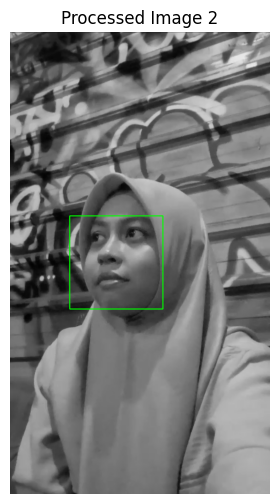

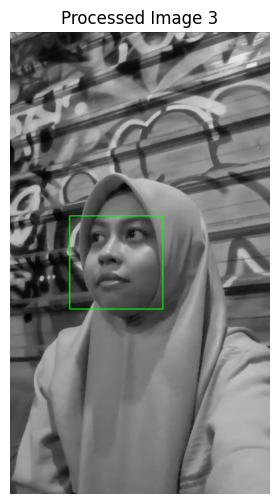

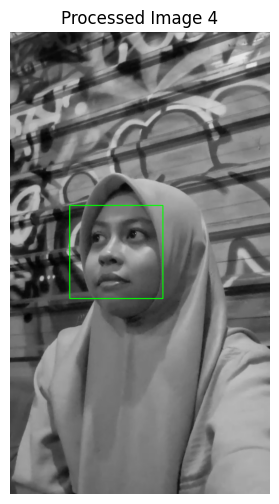

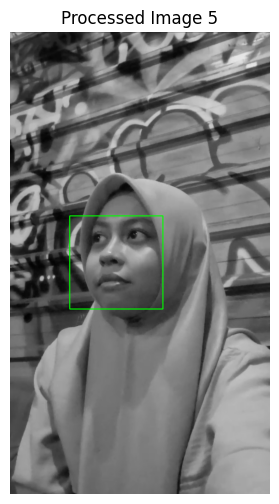

In [60]:
import cv2
import matplotlib.pyplot as plt
import dlib

# Inisialisasi detektor wajah HOG
hog_face_detector = dlib.get_frontal_face_detector()

# Fungsi untuk memproses frame dan deteksi wajah
def process_frames(all_extracted_frames, detector):
    processed_images = []  # List untuk menyimpan gambar yang diproses
    for frame in all_extracted_frames:
        # Konversi frame ke grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Deteksi wajah menggunakan HOG
        faces = detector(gray)

        # Tambahkan kotak hijau di sekitar wajah
        image_with_faces = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        for face in faces:
            x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
            cv2.rectangle(image_with_faces, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Tambahkan gambar yang sudah diproses ke dalam list
        processed_images.append(image_with_faces)

    return processed_images  # Mengembalikan list gambar yang sudah diproses


# Contoh list all_extracted_frames yang berisi frame dari video

# Proses semua frame dalam list all_extracted_frames
processed_images = process_frames(all_extracted_frames, hog_face_detector)

# Tampilkan hasil pemrosesan (opsional)
for i, img in enumerate(processed_images[:5]):  # Batasi tampilan maksimal 5 gambar
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Processed Image {i + 1}')
    plt.axis('off')
    plt.show()


In [61]:
print(f"{len(processed_images)}")

1479


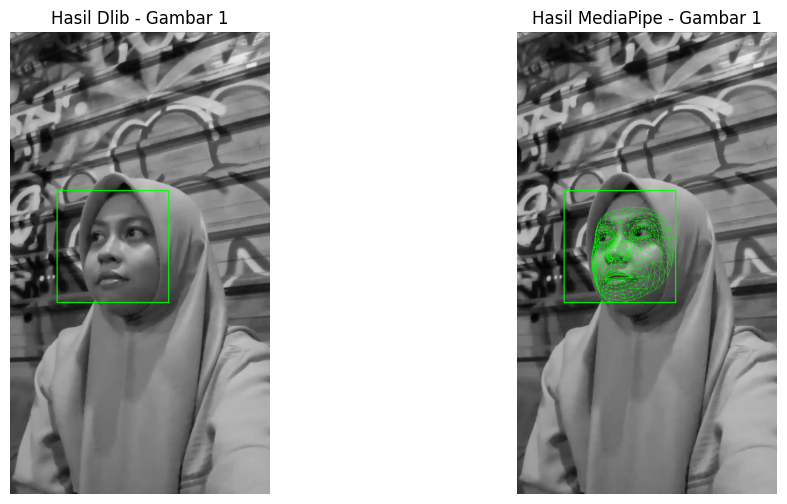

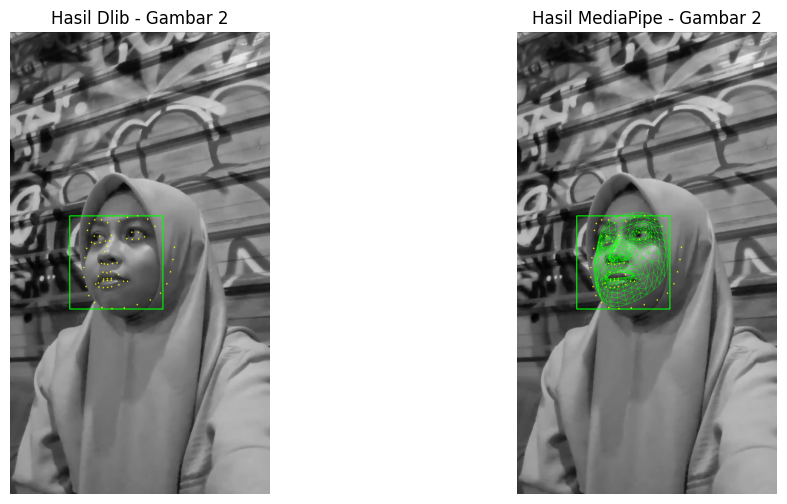

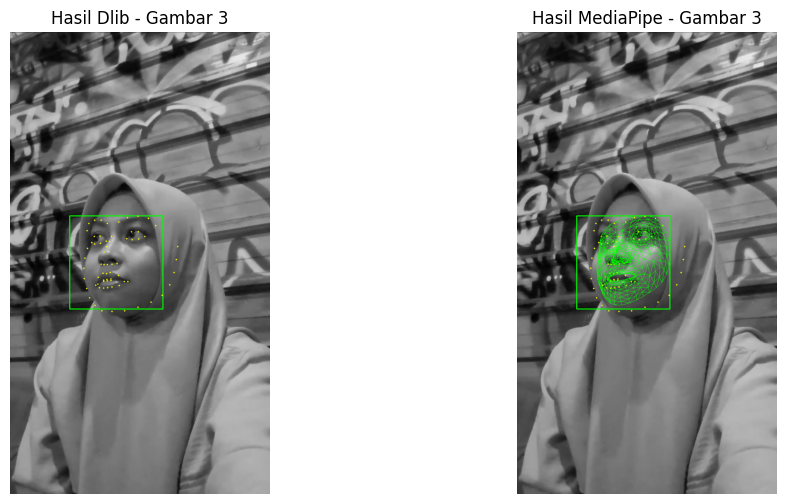

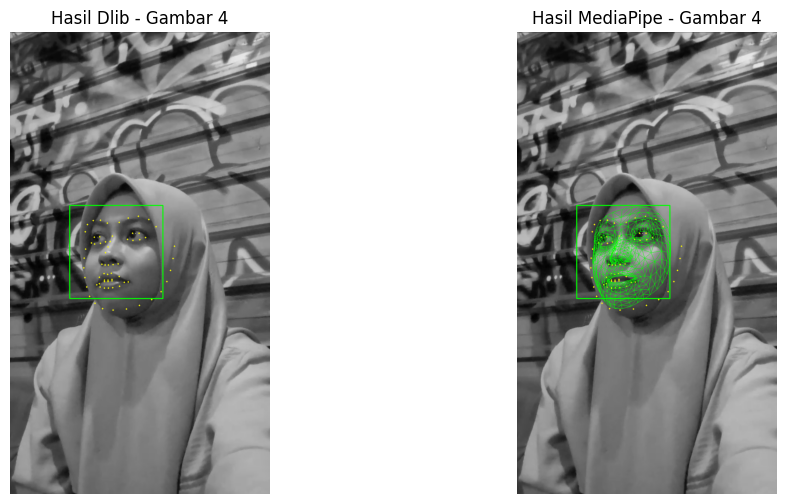

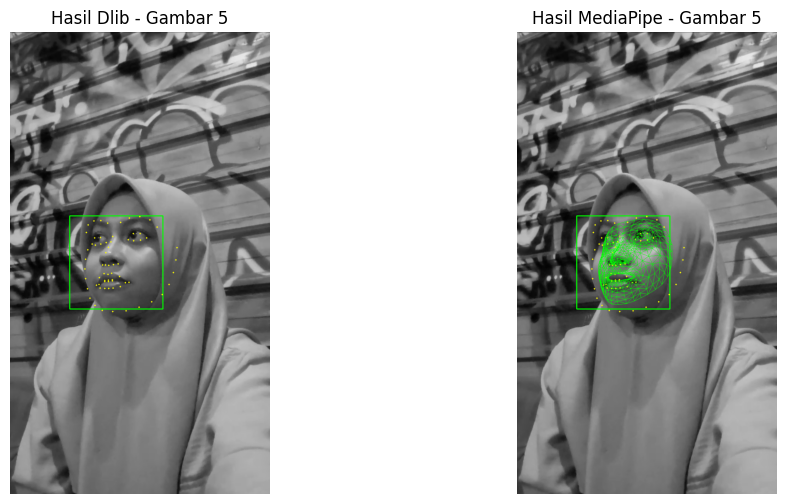

In [62]:
import cv2
import matplotlib.pyplot as plt
import dlib
import mediapipe as mp

# Memuat model Dlib untuk landmark wajah
predictor_path = 'shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)
hog_face_detector = dlib.get_frontal_face_detector()  # Inisialisasi HOG face detector

# Inisialisasi MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    min_detection_confidence=0.5
)

# List untuk menyimpan hasil deteksi Dlib
dlib_processed_images = []
# List untuk menyimpan hasil deteksi MediaPipe
mediapipe_processed_images = []

# Proses setiap gambar dalam processed_images
for image in processed_images:  # Menggunakan gambar yang telah diproses sebelumnya
    # Konversi gambar ke grayscale untuk deteksi wajah dengan Dlib
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah dengan Dlib
    faces = hog_face_detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        for n in range(0, 68):  # Mengambil 68 titik landmark wajah
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image, (x, y), 2, (0, 255, 255), -1)  # Menandai titik landmark dengan warna kuning

    # Simpan gambar yang telah diproses oleh Dlib ke dalam list
    dlib_processed_images.append(image)

# Proses gambar-gambar yang telah diproses oleh Dlib dengan MediaPipe
for idx, image in enumerate(dlib_processed_images):
    # Gambar yang telah diproses Dlib digunakan sebagai input untuk MediaPipe
    image_mesh = image.copy()

    # Proses dengan Face Mesh dari MediaPipe
    results = face_mesh.process(cv2.cvtColor(image_mesh, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=image_mesh,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
            )

    # Simpan gambar hasil deteksi MediaPipe ke dalam list mediapipe_processed_images
    mediapipe_processed_images.append(image_mesh)

for i, (dlib_image, mediapipe_image) in enumerate(zip(dlib_processed_images[:5], mediapipe_processed_images[:5])):
    plt.figure(figsize=(12, 6))

    # Plot hasil Dlib
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(dlib_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Hasil Dlib - Gambar {i + 1}')
    plt.axis('off')

    # Plot hasil MediaPipe
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(mediapipe_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Hasil MediaPipe - Gambar {i + 1}')
    plt.axis('off')

    plt.show()

In [63]:
%pip install mediapipe

# Ekstraksi Fitur

In [64]:
import numpy as np
from scipy.spatial import distance

# Fungsi untuk menghitung Eye Aspect Ratio (EAR)
def calculate_ear(landmarks):
    # Menghitung jarak antara titik-titik pada mata
    # Mata Kiri
    A1 = distance.euclidean(np.array(landmarks[37]), np.array(landmarks[41]))  # Vertikal
    B1 = distance.euclidean(np.array(landmarks[38]), np.array(landmarks[40]))  # Vertikal
    C1 = distance.euclidean(np.array(landmarks[36]), np.array(landmarks[39]))  # Horizontal

    # Mata Kanan
    A2 = distance.euclidean(np.array(landmarks[43]), np.array(landmarks[47]))  # Vertikal
    B2 = distance.euclidean(np.array(landmarks[44]), np.array(landmarks[46]))  # Vertikal
    C2 = distance.euclidean(np.array(landmarks[42]), np.array(landmarks[45]))  # Horizontal

    # Menghitung EAR untuk kedua mata dan rata-ratanya
    ear_left = (B1 + C1) / (2.0 * A1)
    ear_right = (B2 + C2) / (2.0 * A2)

    ear = (ear_left + ear_right) / 2.0
    return ear

# Fungsi untuk menghitung Mouth Aspect Ratio (MAR)
def calculate_mar(landmarks):
    # Menghitung jarak antara titik-titik pada mulut
    A = distance.euclidean(np.array(landmarks[62]), np.array(landmarks[66]))  # Jarak vertikal
    B = distance.euclidean(np.array(landmarks[61]), np.array(landmarks[67]))  # Jarak horizontal
    C = distance.euclidean(np.array(landmarks[60]), np.array(landmarks[64]))  # Jarak horizontal
    D = distance.euclidean(np.array(landmarks[59]), np.array(landmarks[63]))  # Jarak horizontal

    # Menghitung MAR menggunakan formula
    mar = (B + C + D) / (2.0 * A)
    return mar

In [65]:
# Daftar untuk menyimpan hasil per gambar
results = []

# Proses setiap gambar dari list hasil MediaPipe
for idx, image in enumerate(mediapipe_processed_images):  # Gambar sudah dalam bentuk array, tidak perlu membaca dengan cv2.imread
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = hog_face_detector(gray)

    # List untuk menyimpan data per wajah
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []

    for face in faces:  # Loop untuk setiap wajah yang terdeteksi
        landmarks = predictor(gray, face)  # Dapatkan landmark wajah

        # Ubah objek landmark dlib menjadi list koordinat (x, y)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        # Hitung EAR dan MAR
        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        # Tambahkan nilai EAR dan MAR ke list
        ear_values.append(ear)
        mar_values.append(mar)

        # Ekstrak koordinat x dan y untuk landmark hidung (landmark 30)
        nose_x = landmarks.part(30).x
        nose_y = landmarks.part(30).y

        # Tambahkan koordinat ke list
        nose_x_coords.append(nose_x)
        nose_y_coords.append(nose_y)

    # Simpan hasil untuk gambar saat ini ke dalam dictionary
    results.append({
        "Gambar": idx + 1,
        "EAR": ear_values,
        "MAR": mar_values,
        "Nose X": nose_x_coords,
        "Nose Y": nose_y_coords,
    })

# Cetak hasil per gambar
for result in results:
    print(f"Gambar {result['Gambar']}:")
    print("  Eye Aspect Ratios:", result["EAR"])
    print("  Mouth Aspect Ratios:", result["MAR"])
    print("  Nose X Coordinates:", result["Nose X"])
    print("  Nose Y Coordinates:", result["Nose Y"])

# Cetak hasil akhir untuk semua gambar
print("Hasil Akhir:")
for result in results:
    print(f"Gambar {result['Gambar']}: {result}")

C:\Users\acer\AppData\Local\Temp\ipykernel_8180\3515431958.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  mar = (B + C + D) / (2.0 * A)


Gambar 1:
  Eye Aspect Ratios: [1.9845183913209234]
  Mouth Aspect Ratios: [10.49611926543218]
  Nose X Coordinates: [269]
  Nose Y Coordinates: [608]
Gambar 2:
  Eye Aspect Ratios: [1.59507157468909]
  Mouth Aspect Ratios: [11.479916906698637]
  Nose X Coordinates: [264]
  Nose Y Coordinates: [611]
Gambar 3:
  Eye Aspect Ratios: [1.617031487896627]
  Mouth Aspect Ratios: [10.209463659603518]
  Nose X Coordinates: [263]
  Nose Y Coordinates: [613]
Gambar 4:
  Eye Aspect Ratios: [1.8108238382645976]
  Mouth Aspect Ratios: [7.350751032942593]
  Nose X Coordinates: [274]
  Nose Y Coordinates: [609]
Gambar 5:
  Eye Aspect Ratios: []
  Mouth Aspect Ratios: []
  Nose X Coordinates: []
  Nose Y Coordinates: []
Gambar 6:
  Eye Aspect Ratios: [1.646061057218808]
  Mouth Aspect Ratios: [5.131397946609303]
  Nose X Coordinates: [274]
  Nose Y Coordinates: [614]
Gambar 7:
  Eye Aspect Ratios: []
  Mouth Aspect Ratios: []
  Nose X Coordinates: []
  Nose Y Coordinates: []
Gambar 8:
  Eye Aspect Rati

In [66]:
import csv
import json

# Daftar untuk menyimpan hasil per gambar
results = []

# Proses setiap gambar dari list hasil MediaPipe
for idx, image in enumerate(mediapipe_processed_images):  # Gambar sudah dalam bentuk array, tidak perlu membaca dengan cv2.imread
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = hog_face_detector(gray)

    # List untuk menyimpan data per wajah
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []

    for face in faces:  # Loop untuk setiap wajah yang terdeteksi
        landmarks = predictor(gray, face)  # Dapatkan landmark wajah

        # Ubah objek landmark dlib menjadi list koordinat (x, y)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        # Hitung EAR dan MAR
        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        # Tambahkan nilai EAR, MAR, dan koordinat hidung ke list
        ear_values.append(ear)
        mar_values.append(mar)
        nose_x_coords.append(landmarks.part(30).x)
        nose_y_coords.append(landmarks.part(30).y)

    # Simpan hasil untuk gambar saat ini ke dalam dictionary
    results.append({
        "Gambar": idx + 1,
        "EAR": ear_values,
        "MAR": mar_values,
        "Nose X": nose_x_coords,
        "Nose Y": nose_y_coords
    })

# Menyimpan hasil ekstraksi fitur ke dalam file CSV
csv_file_path = 'ekstraksi_fitur.csv'

header = ['Gambar', 'EAR', 'MAR', 'Nose X', 'Nose Y']

# Menulis data ke file CSV
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Menulis header

    for result in results:
        for ear, mar, nose_x, nose_y in zip(result['EAR'], result['MAR'], result['Nose X'], result['Nose Y']):
            writer.writerow([result['Gambar'], ear, mar, nose_x, nose_y])

print(f"Hasil berhasil disimpan dalam {csv_file_path}")

# Menyimpan hasil ekstraksi fitur ke dalam file JSON
json_file_path = 'ekstraksi_fitur.json'

data_to_save = []

for result in results:
    for ear, mar, nose_x, nose_y in zip(result['EAR'], result['MAR'], result['Nose X'], result['Nose Y']):
        data_to_save.append({
            "Gambar": result['Gambar'],
            "EAR": ear,
            "MAR": mar,
            "Nose X": nose_x,
            "Nose Y": nose_y
        })

with open(json_file_path, mode='w') as file:
    json.dump(data_to_save, file, indent=4)

print(f"Hasil berhasil disimpan dalam {json_file_path}")

C:\Users\acer\AppData\Local\Temp\ipykernel_8180\3515431958.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  mar = (B + C + D) / (2.0 * A)


Hasil berhasil disimpan dalam ekstraksi_fitur.csv
Hasil berhasil disimpan dalam ekstraksi_fitur.json


C:\Users\acer\AppData\Local\Temp\ipykernel_8180\3515431958.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  mar = (B + C + D) / (2.0 * A)


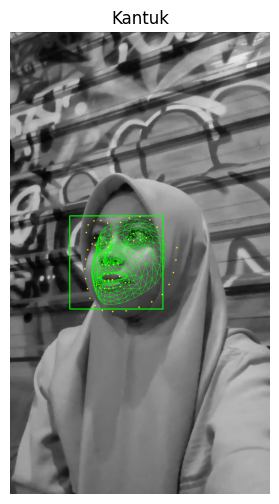


Hasil Ekstraksi Fitur untuk Gambar Kantuk:
  Eye Aspect Ratios (EAR): [1.59507157468909]
  Mouth Aspect Ratios (MAR): [11.479916906698637]
  Nose X Coordinates: [264]
  Nose Y Coordinates: [611]


In [67]:
import matplotlib.pyplot as plt
import cv2

# Daftar untuk menyimpan hasil per gambar
results = []

# Proses setiap gambar dari list hasil MediaPipe
for idx, image in enumerate(mediapipe_processed_images):  # Gambar sudah dalam bentuk array, tidak perlu membaca dengan cv2.imread
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = hog_face_detector(gray)

    # List untuk menyimpan data per wajah
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []

    for face in faces:  # Loop untuk setiap wajah yang terdeteksi
        landmarks = predictor(gray, face)  # Dapatkan landmark wajah

        # Ubah objek landmark dlib menjadi list koordinat (x, y)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        # Hitung EAR dan MAR
        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        # Tambahkan nilai EAR dan MAR ke list
        ear_values.append(ear)
        mar_values.append(mar)

        # Ekstrak koordinat x dan y untuk landmark hidung (landmark 30)
        nose_x = landmarks.part(30).x
        nose_y = landmarks.part(30).y

        # Tambahkan koordinat ke list
        nose_x_coords.append(nose_x)
        nose_y_coords.append(nose_y)

    # Simpan hasil untuk gambar saat ini ke dalam dictionary
    results.append({
        "Gambar": idx + 1,
        "EAR": ear_values,
        "MAR": mar_values,
        "Nose X": nose_x_coords,
        "Nose Y": nose_y_coords,
    })

# Tampilkan gambar kelima dan hasil ekstraksi fitur dari gambar kelima
if len(mediapipe_processed_images) >= 10:  # Pastikan ada setidaknya 5 gambar
    # Menampilkan gambar kelima
    fifth_image = mediapipe_processed_images[4] 
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(fifth_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Kantuk")
    plt.axis('off')
    plt.show()

    # Menampilkan hasil ekstraksi fitur gambar kelima
    fifth_result = results[1]  # Hasil dari gambar kelima
    print(f"\nHasil Ekstraksi Fitur untuk Gambar Kantuk:")

    if fifth_result["EAR"]:
        print(f"  Eye Aspect Ratios (EAR): {fifth_result['EAR']}")
        print(f"  Mouth Aspect Ratios (MAR): {fifth_result['MAR']}")
        print(f"  Nose X Coordinates: {fifth_result['Nose X']}")
        print(f"  Nose Y Coordinates: {fifth_result['Nose Y']}")
    else:
        print("  Tidak ada wajah yang terdeteksi pada gambar ke tujuh.")
else:
    print("Terdapat kurang dari 10 gambar dalam daftar.")

# Model Random Forest

Memuat dan Menyiapkan data

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import joblib
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import numpy as np

In [69]:
import pandas as pd

# Membaca data dari file CSV
df = pd.read_csv('ekstraksi_fitur_label.csv')

# Memisahkan fitur dan label
X = df[['EAR', 'MAR', 'Nose X', 'Nose Y']]  # Fitur
y = df['Label']  # Label

Konversi Label ke Angka untuk Random Forest

In [70]:
from sklearn.preprocessing import LabelEncoder

# Mengonversi label menjadi angka
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Mengubah label ke angka

Split Data

In [71]:
from sklearn.model_selection import train_test_split

# Membagi data menja
# di data latih dan data uji (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
def add_noise(data, noise_level=0.01):
    noisy_data = data.copy()
    for col in data.columns:
        if data[col].dtype != 'object':  # Hanya untuk fitur numerik
            noise = np.random.normal(0, noise_level * data[col].std(), size=data[col].shape)
            noisy_data[col] += noise
    return noisy_data

X_train_noisy = add_noise(X_train, noise_level=0.05)

c:\laragon\bin\python\python-3.10\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [73]:
from sklearn.impute import SimpleImputer

# Mengisi nilai NaN dengan rata-rata kolom
imputer = SimpleImputer(strategy="mean")
X_train_noisy_imputed = imputer.fit_transform(X_train_noisy)


c:\laragon\bin\python\python-3.10\lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['MAR']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [74]:
from imblearn.over_sampling import SMOTE

# Oversampling menggunakan SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_noisy_imputed, y_train)


Latih Model

In [75]:
# 3. Melatih model dengan data yang sudah diaugmentasi
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Model dengan parameter untuk mengurangi overfitting
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42
)

# Latih model
model.fit(X_train_smote, y_train_smote)

# Terapkan imputasi pada X_test
X_test_imputed = imputer.transform(X_test)


c:\laragon\bin\python\python-3.10\lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['MAR']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [76]:
# Evaluasi pada data latih
y_pred_train = model.predict(X_train_smote)
print("Evaluasi pada Data Latih:")
print(f"Akurasi: {accuracy_score(y_train_smote, y_pred_train)}")
print(classification_report(y_train_smote, y_pred_train))

# Evaluasi pada data uji
y_pred_test = model.predict(X_test_imputed)
print("\nEvaluasi pada Data Uji:")
print(f"Akurasi: {accuracy_score(y_test, y_pred_test)}")
print(classification_report(y_test, y_pred_test))

Evaluasi pada Data Latih:
Akurasi: 0.8625
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       240
           1       0.81      0.94      0.87       240

    accuracy                           0.86       480
   macro avg       0.87      0.86      0.86       480
weighted avg       0.87      0.86      0.86       480


Evaluasi pada Data Uji:
Akurasi: 0.8041237113402062
              precision    recall  f1-score   support

           0       0.89      0.79      0.83        61
           1       0.70      0.83      0.76        36

    accuracy                           0.80        97
   macro avg       0.79      0.81      0.80        97
weighted avg       0.82      0.80      0.81        97



Simpan Model

In [77]:
import joblib

# Simpan model ke file
joblib.dump(model, 'model_random_forest.pkl')
print("Model berhasil disimpan ke file 'model_random_forest.pkl'")

Model berhasil disimpan ke file 'model_random_forest.pkl'


In [78]:
print(model)  # Jika model sudah didefinisikan, outputnya akan menampilkan informasi model

RandomForestClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)
